In [2]:
import numpy as np
import tenpy.linalg.np_conserved as npc
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.networks.site import SpinSite
from tenpy.networks.mps import TransferMatrix
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.models.lattice import Chain
from tenpy.linalg import np_conserved as npc
import numpy as np
#tenpy.tools.misc.setup_logging(to_stdout="INFO")
from tenpy.models.lattice import Lattice
from tenpy.models.model import CouplingModel,MPOModel
from tenpy.networks.site import SpinHalfSite, kron
from scipy.optimize import curve_fit
import pickle
import MPSToolBox as my

Imported MPSToolBox


[[-1, -1], [1, 1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [1, 1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [1, 1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [1, 1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [1, 1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [-1, -1], [1, 1], [-1, -1], [-1, -1], [-1, -1], [-1, -1]]
-1.18806847

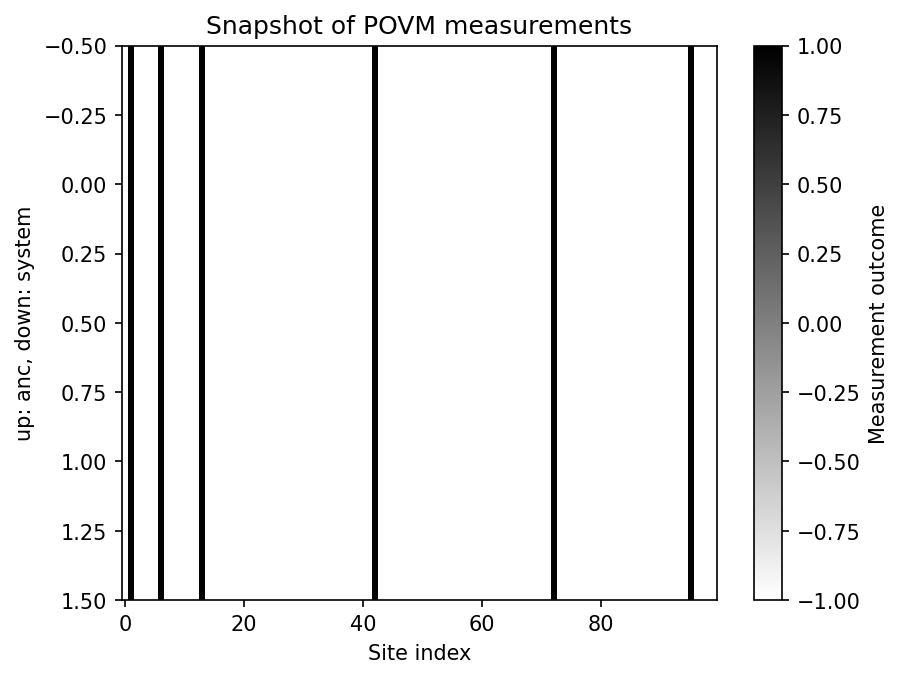

In [4]:
'''
Temperary testing code
'''
psi = my.load_pkl("../wavefunctions/CritIsingModel_L100_chi300_PBC_.pkl")
povm_1 = my.weak_measurement_pauli(my.sZ, beta=2, real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=np.inf, real=True)
rng = np.random.default_rng(seed=35)
s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
print(s)
print(weight)

s = np.array(s)
plt.imshow(s.T, aspect='auto', cmap='binary')
plt.xlabel('Site index')
plt.ylabel('up: anc, down: system')
plt.title('Snapshot of POVM measurements')
plt.colorbar(label='Measurement outcome')
plt.show()


[[-1, -1], [1, 1], [-1, -1], [-1, 1], [1, 1], [1, -1], [1, -1], [-1, -1], [-1, -1], [1, -1]]
-0.0006983154624430689


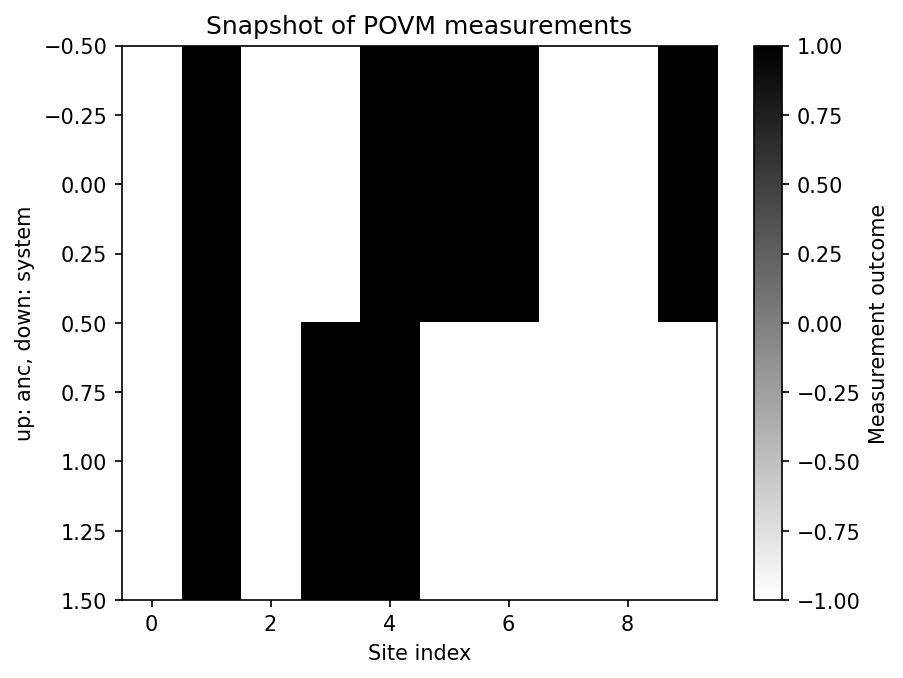

[-1  1 -1 -1  1  1  1 -1 -1  1] [-1  1 -1  1  1 -1 -1 -1 -1 -1]


In [10]:
psi = my.load_pkl("../wavefunctions/CritIsingModel_L10_chi300_PBC_.pkl")
povm_1 = my.weak_measurement_pauli(my.sZ, beta=0., real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=np.inf, real=True)
rng = np.random.default_rng(seed=35)
s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
print(s)
print(weight)

s = np.array(s)
plt.imshow(s.T, aspect='auto', cmap='binary')
plt.xlabel('Site index')
plt.ylabel('up: anc, down: system')
plt.title('Snapshot of POVM measurements')
plt.colorbar(label='Measurement outcome')
plt.show()

s_anc = s[:,0]
s_sys = s[:,1]
print(s_anc, s_sys)

In [32]:
psi = my.load_pkl("../wavefunctions/CritIsingModel_L10_chi300_PBC_.pkl")
beta_anc = 0.2
beta_sys = np.inf
povm_1 = my.weak_measurement_pauli(my.sZ, beta=beta_anc, real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=beta_sys, real=True)
N = 200 # Number of measurements

outcomes_anc = []
outcomes_sys = []
for seed in range(N):
    rng = np.random.default_rng(seed=seed)
    s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
    s = np.array(s)
    s_anc = s[:,0]
    s_sys = s[:,1]
    outcomes_anc.append(s_anc)
    outcomes_sys.append(s_sys)
    
outcomes_anc = np.array(outcomes_anc)
outcomes_sys = np.array(outcomes_sys)

# save the outcomes as numpy arrays
# np.save('outcomes_anc.npy', outcomes_anc)
# np.save('outcomes_sys.npy', outcomes_sys)


In [5]:
def second_moment_snapshot(outcomes_anc, observable):
    r'''
    Consider a system attached to some ancilla degrees of freedom. We are interested in computing \sum_{p_s} p_s \langle O \rangle^2_s for some observable O after measuring the ancilla, where p_s is the probability of measuring the state s in the ancilla and \langle O \rangle_s is the expectation value of O in the system conditioned on the ancilla measurement outcome s.
    Note that the inequality \sum_{p_s} p_s (\langle O \rangle_s - f(s))^2 \leq 0 holds for any function f(s).
    We have \sum_{p_s} p_s \langle O \rangle^2_s \leq 2 \leq \sum_{p_s} 2 p_s \langle O \rangle_s f(s) - \sum_{p_s} p_s f(s)^2.
    From snapshot data, the right-hand side can be approximated as (1/N) \sum_i 2 O_i f(s_i) - (1/N) \sum_i f(s_i)^2, where i is the index of measurements, s_i is the measurement outcome of the ancilla in the i-th measurement, and O_i is the measured value of O in the system in the i-th measurement.
    Thus we want to find a function f(s) that maximizes (1/N) \sum_i 2 O_i f(s_i) - (1/N) \sum_i f(s_i)^2.
    
    outcomes_anc: numpy array of shape (N, L) where N is the number of measurements and L is the length of the system.
    observable: numpy array of shape (N,) where N is the number of measurements.
    
    Returns:
    The maximum value of (1/N) \sum_i 2 O_i f(s_i) - (1/N) \sum_i f(s_i)^2.
    '''
    outcomes_anc = np.asarray(outcomes_anc, dtype=np.int64)
    observable = np.asarray(observable, dtype=float)
    if outcomes_anc.shape[0] != observable.shape[0]:
        raise ValueError("Number of ancilla outcomes and observables must match.")

    _, labels, counts = np.unique(outcomes_anc, axis=0, return_inverse=True, return_counts=True)
    sums = np.bincount(labels, weights=observable, minlength=counts.size)
    return np.sum((sums * sums) / counts) / observable.size


In [24]:
observable = outcomes_sys[:,0]

In [25]:
second_moment_snapshot(outcomes_anc, observable)

np.float64(0.96)

In [ ]:
psi = my.load_pkl("../wavefunctions/CritIsingModel_L10_chi300_PBC_.pkl")
beta_anc = 0.3
beta_sys = np.inf
povm_1 = my.weak_measurement_pauli(my.sZ, beta=beta_anc, real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=beta_sys, real=True)
N = 100000 # Number of measurements

outcomes_anc = []
outcomes_sys = []
for seed in range(N):
    rng = np.random.default_rng(seed=seed)
    s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
    s = np.array(s)
    s_anc = s[:,0]
    s_sys = s[:,1]
    outcomes_anc.append(s_anc)
    outcomes_sys.append(s_sys)
    
outcomes_anc = np.array(outcomes_anc)
outcomes_sys = np.array(outcomes_sys)
observable = outcomes_sys[:,0]
# save the outcomes as numpy arrays
np.save('CritIsing_L10_beta0.3_outcomes_anc.npy', outcomes_anc)
np.save('CritIsing_L10_beta0.3_outcomes_sys.npy', outcomes_sys)


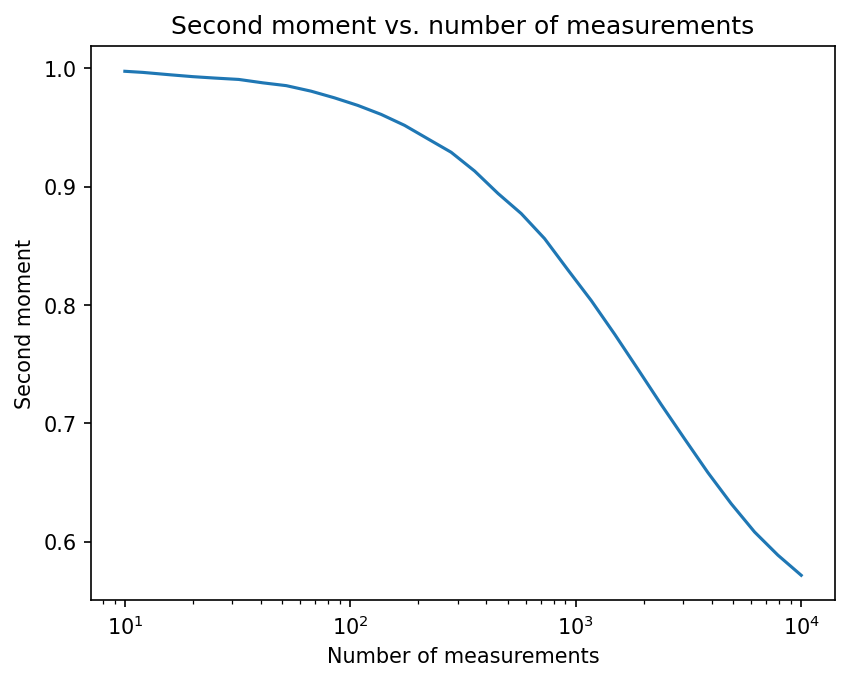

In [32]:
observable = outcomes_sys[:,0]
N_list = np.logspace(1, 4, 30).astype(int)
N_shuffle = 100
results = []
for n in N_list:
    result_i = []
    for i in range(psi.L):
        for _ in range(N_shuffle):
            observable = outcomes_sys[:,i]
            
            # shuffle outcomes_anc together with observable
            indices = np.random.permutation(N)
            
            s = outcomes_anc[indices,:][:n]
            o = observable[indices][:n]
            result_i.append(second_moment_snapshot(s, o))
    results.append(np.mean(result_i))
plt.semilogx(N_list, results)
plt.xlabel('Number of measurements')
plt.ylabel('Second moment')
plt.title('Second moment vs. number of measurements')
plt.show()

In [22]:
psi = my.load_pkl("../wavefunctions/CritIsingModel_L10_chi300_PBC_.pkl")
beta_anc = 0.5
beta_sys = np.inf
povm_1 = my.weak_measurement_pauli(my.sZ, beta=beta_anc, real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=beta_sys, real=True)
N = 10000 # Number of measurements

outcomes_anc = []
outcomes_sys = []
for seed in range(N):
    rng = np.random.default_rng(seed=seed)
    s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
    s = np.array(s)
    s_anc = s[:,0]
    s_sys = s[:,1]
    outcomes_anc.append(s_anc)
    outcomes_sys.append(s_sys)
    
outcomes_anc = np.array(outcomes_anc)
outcomes_sys = np.array(outcomes_sys)
observable = outcomes_sys[:,0]
# save the outcomes as numpy arrays
# np.save('outcomes_anc.npy', outcomes_anc)
# np.save('outcomes_sys.npy', outcomes_sys)


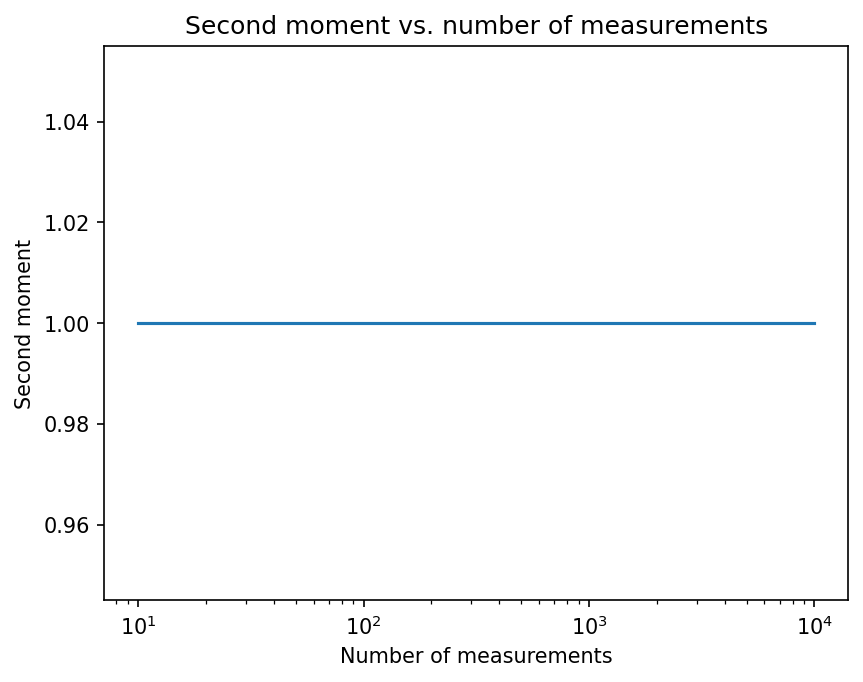

In [ ]:
observable = outcomes_sys[:,0]
N_list = np.logspace(1, 4, 20).astype(int)
N_shuffle = 10
results = []
for n in N_list:
    result_i = []
    for i in range(psi.L):
        for _ in range(N_shuffle):
            observable = outcomes_sys[:,i]
            
            # shuffle outcomes_anc together with observable
            indices = np.random.permutation(N)
            
            s = outcomes_anc[indices,:][:n]
            o = observable[indices][:n]
            result_i.append(second_moment_snapshot(s, o))
    results.append(np.mean(result_i))
plt.semilogx(N_list, results)
plt.xlabel('Number of measurements')
plt.ylabel('Second moment')
plt.title('Second moment vs. number of measurements')
plt.show()

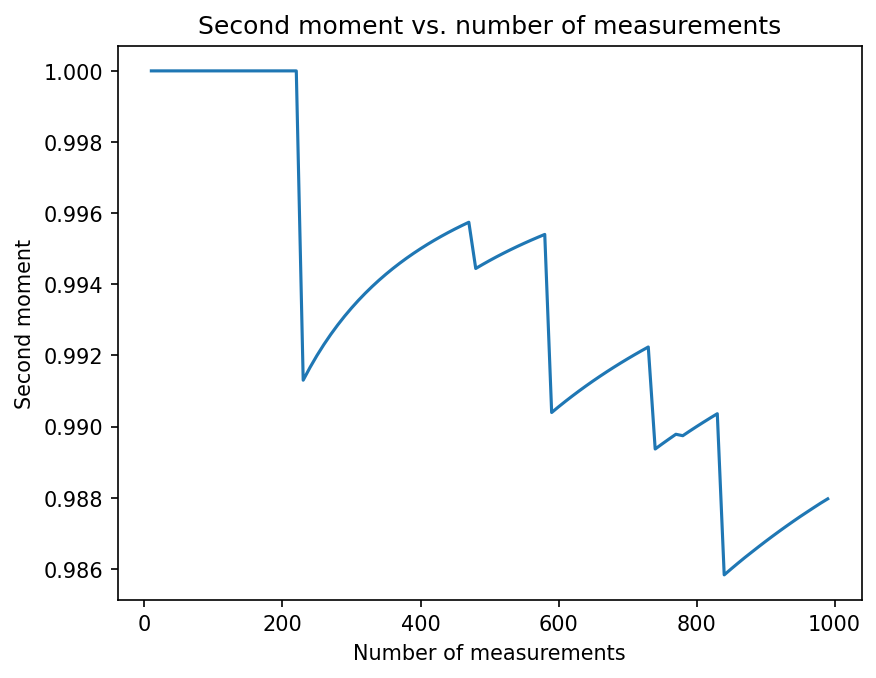

In [ ]:
psi = my.load_pkl("../wavefunctions/CritIsingModel_L20_chi300_PBC_.pkl")
beta_anc = 1.0
beta_sys = np.inf
povm_1 = my.weak_measurement_pauli(my.sZ, beta=beta_anc, real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=beta_sys, real=True)
N = 1000 # Number of measurements

outcomes_anc = []
outcomes_sys = []
for seed in range(N):
    rng = np.random.default_rng(seed=seed)
    s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
    s = np.array(s)
    s_anc = s[:,0]
    s_sys = s[:,1]
    outcomes_anc.append(s_anc)
    outcomes_sys.append(s_sys)
    
outcomes_anc = np.array(outcomes_anc)
outcomes_sys = np.array(outcomes_sys)

# save the outcomes as numpy arrays
# np.save('outcomes_anc.npy', outcomes_anc)
# np.save('outcomes_sys.npy', outcomes_sys)


observable = outcomes_sys[:,0]
N_list = np.arange(10, N, 10)
results = []
for n in range(10, N, 10):
    s = outcomes_anc[:n]
    o = observable[:n]
    result = second_moment_snapshot(s, o)
    results.append(result)
plt.plot(N_list, results)
plt.xlabel('Number of measurements')
plt.ylabel('Second moment')
plt.title('Second moment vs. number of measurements')
plt.show()

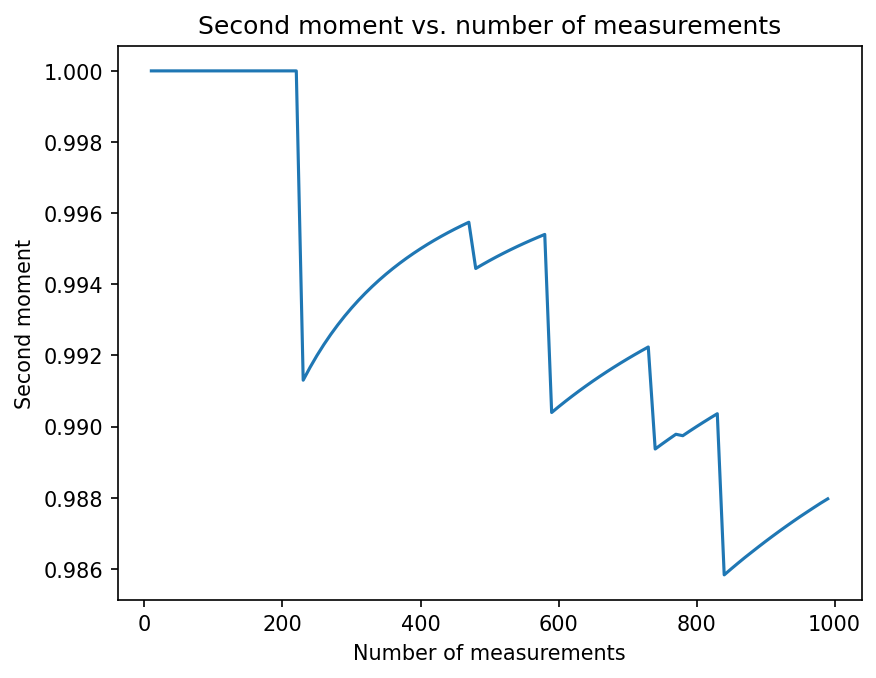

In [40]:
psi = my.load_pkl("../wavefunctions/CritIsingModel_L20_chi300_PBC_.pkl")
beta_anc = 1.0
beta_sys = np.inf
povm_1 = my.weak_measurement_pauli(my.sZ, beta=beta_anc, real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=beta_sys, real=True)
N = 1000 # Number of measurements

outcomes_anc = []
outcomes_sys = []
for seed in range(N):
    rng = np.random.default_rng(seed=seed)
    s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
    s = np.array(s)
    s_anc = s[:,0]
    s_sys = s[:,1]
    outcomes_anc.append(s_anc)
    outcomes_sys.append(s_sys)
    
outcomes_anc = np.array(outcomes_anc)
outcomes_sys = np.array(outcomes_sys)

# save the outcomes as numpy arrays
# np.save('outcomes_anc.npy', outcomes_anc)
# np.save('outcomes_sys.npy', outcomes_sys)


observable = outcomes_sys[:,0]
N_list = np.arange(10, N, 10)
results = []
for n in range(10, N, 10):
    s = outcomes_anc[:n]
    o = observable[:n]
    result = second_moment_snapshot(s, o)
    results.append(result)
plt.plot(N_list, results)
plt.xlabel('Number of measurements')
plt.ylabel('Second moment')
plt.title('Second moment vs. number of measurements')
plt.show()

In [ ]:
psi = my.load_pkl("../wavefunctions/CritIsingModel_L20_chi300_PBC_.pkl")
beta_anc = 1.0
beta_sys = np.inf
povm_1 = my.weak_measurement_pauli(my.sZ, beta=beta_anc, real=True)
povm_2 = my.weak_measurement_pauli(my.sZ, beta=beta_sys, real=True)
N = 1000 # Number of measurements

outcomes_anc = []
outcomes_sys = []
for seed in range(N):
    rng = np.random.default_rng(seed=seed)
    s, weight = my.sample_multi_povm_measurements(psi, first_site=0, ops=[[povm_1, povm_2]]*psi.L, rng=rng)
    s = np.array(s)
    s_anc = s[:,0]
    s_sys = s[:,1]
    outcomes_anc.append(s_anc)
    outcomes_sys.append(s_sys)
    
outcomes_anc = np.array(outcomes_anc)
outcomes_sys = np.array(outcomes_sys)

# save the outcomes as numpy arrays
# np.save('outcomes_anc.npy', outcomes_anc)
# np.save('outcomes_sys.npy', outcomes_sys)


observable = outcomes_sys[:,0]
N_list = np.arange(10, N, 10)
results = []
for n in range(10, N, 10):
    s = outcomes_anc[:n]
    o = observable[:n]
    result = second_moment_snapshot(s, o)
    results.append(result)
plt.plot(N_list, results)
plt.xlabel('Number of measurements')
plt.ylabel('Second moment')
plt.title('Second moment vs. number of measurements')
plt.show()